# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
import numpy as np
# pandas version: 2.2.2
import pandas as pd
# seaborn version: 0.13.2
import seaborn as sns
# matplotlib version: 3.10.0
import matplotlib.pyplot as plt
# PIL version: 11.1.0
!pip install Pillow
!pip install opencv-python
!pip install tensorflow
!pip install keras
!pip install imblearn
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [45]:
# Import essential libraries

import os
from PIL import Image
import tensorflow
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras import datasets,layers,models,callbacks,optimizers
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.regularizers import l2
import cv2
from sklearn.preprocessing import LabelEncoder


Load the dataset.

In [3]:
# Load and unzip the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/data.zip' -d '/content/data-1'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data-1/data/Paper/file_560.png  
  inflating: /content/data-1/data/Glass/file_620.png  
  inflating: /content/data-1/data/Glass/file_676.png  
  inflating: /content/data-1/data/Glass/file_177.png  
  inflating: /content/data-1/data/Glass/file_749.png  
  inflating: /content/data-1/data/Glass/file_460.png  
  inflating: /content/data-1/data/Glass/file_127.png  
  inflating: /content/data-1/data/Glass/file_438.png  
  inflating: /content/data-1/data/Glass/file_132.png  
  inflating: /content/data-1/data/Glass/file_98.png  
  inflating: /content/data-1/data/Glass/file_427.png  
  inflating: /content/data-1/data/Glass/file_351.png  
  inflating: /content/data-1/data/Glass/file_74.png  
  inflating: /content/data-1/data/Glass/file_377.png  
  inflating: /content/data-1/data/Glass/file_445.png  
  inflating: /content/data-1/data/Glass/file_229.png  
  inflating: /content/data-1/data/Glass/file_658.png  
  inflating: /co

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images
def load_images(folder,target_size=(224,224)):
    imgs=[]
    for filename in os.listdir(folder):
      if filename.endswith(('.png','.jpg','.jpeg')):
        img_path=os.path.join(folder,filename)
        try:
          img=cv2.imread(img_path)
          img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
          if img is None:
            print("Error")
            continue
          resized_img=cv2.resize(img,target_size)
          imgs.append(resized_img)
        except Exception as e:
            print(f"Error occurred while processing {imgs}:{e}")
            continue
    return np.array(imgs)

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [46]:
# Get the images and their labels
def load_images_and_labels(folder,tgt_size=(224,224)):
  imgs2=[]
  labels=[]
  label_map={}
  label_cnt=0
  if not os.path.exists(folder):
    print("No directory")
    return np.array(imgs),np.array(labels)
  for label_name in os.listdir(folder):
    label_dir=os.path.join(folder,label_name)
    imgs1=load_images(folder,tgt_size)
    if not os.path.isdir(label_dir):
      continue
    if label_name not in label_map:
      label_map[label_name]=label_cnt
      label_cnt+=1
    label_imgs=load_images(label_dir,tgt_size)
    imgs2.extend(label_imgs)
    labels.extend([label_map[label_name]]* len(label_imgs))
  return np.array(imgs2),np.array(labels)
dataset_dir='/content/data-1/data'
imgs,labels=load_images_and_labels(dataset_dir)
if len(imgs)>0:
  print(f"Loaded {len(imgs)} images.")
  print(f"Loaded {len(labels)} labels.")
  print(f"Image shape: {imgs[0].shape}")
  print(f"Unique labels:{np.unique(labels)}")

#   X_train,X_test,y_train,y_test=train_test_split(imgs,labels,test_size=0.2,random_state=42)
#   print(f"Train size:{len(X_train)}")
#   print(f"Test size:{len(X_test)}")

Loaded 7625 images.
Loaded 7625 labels.
Image shape: (224, 224, 3)
Unique labels:[0 1 2 3 4 5 6]


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

label name Glass
label name Food_Waste
label name Cardboard
label name Plastic
label name Other
label name Paper
label name Metal


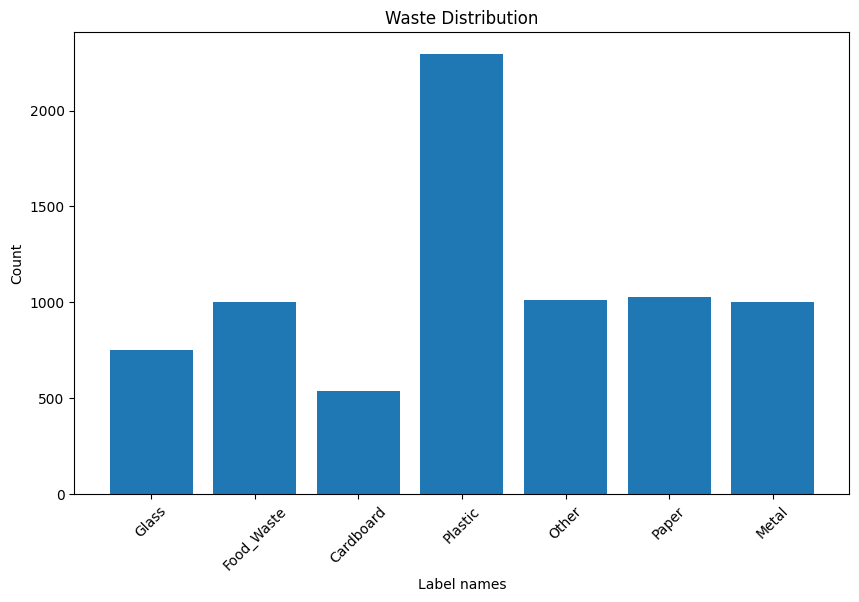

In [6]:
# Visualise Data Distribution

def bar_plot_distri(folder):
  class_cnt={}
  if not os.path.exists(folder):
    print(f"Error:Dataset not found {folder}")
    return
  for label_name in os.listdir(folder):
     print('label name',label_name)
     label_dir=os.path.join(folder,label_name)
     if os.path.isdir(label_dir):
      class_cnt[label_name]=len(os.listdir(label_dir))
  labels=class_cnt.keys()
  vals=class_cnt.values()
  plt.figure(figsize=(10,6))
  plt.bar(labels,vals)
  plt.xlabel('Label names')
  plt.ylabel('Count')
  plt.title('Waste Distribution')
  plt.xticks(rotation=45)
  plt.show()
dataset_dir='/content/data-1/data'
bar_plot_distri(dataset_dir)

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

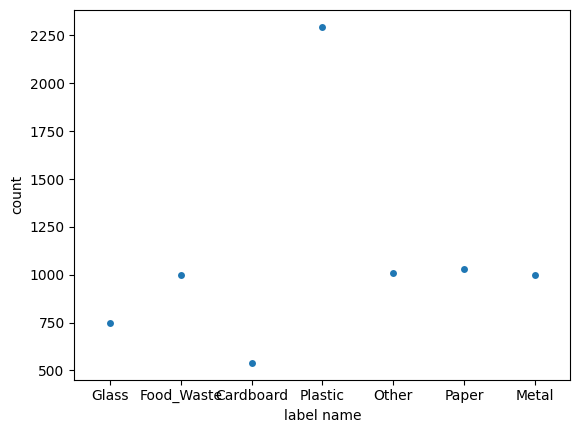

In [7]:
# Visualise Sample Images (across different labels)
def visualize_imgs(folder):
  class_cnt={}
  for label_name in os.listdir(folder):
      label_dir=os.path.join(folder,label_name)
      if os.path.isdir(label_dir):
        class_cnt[label_name]=len(os.listdir(label_dir))
  labels=class_cnt.keys()
  vals=class_cnt.values()
  sns.stripplot(x=labels,y=vals)
  plt.xlabel('label name')
  plt.ylabel('count')

dataset_dir='/content/data-1/data'
visualize_imgs(dataset_dir)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set
def min_max_img_dim(folder):
  min_height=float('inf')
  min_width=float('inf')
  max_height=0
  max_width=0
  img_cnt=0
  for label_name in os.listdir(folder):
    label_dir=os.path.join(folder,label_name)
    img_1=load_images(label_dir)
    try:
        height,width,channels=img_1[0].shape
        min_height=min(min_height,height)
        min_width=min(min_width,width)
        max_height=max(max_height,height)
        max_width=max(max_width,width)
        img_cnt+=1
    except Exception as e:
        print(f"Can't open img:{img_1}")
  if img_cnt>0:
    print(f"Total imgs processed:{img_cnt}")
    print(f"smallest dimension:{min_height}x{min_width}")
    print(f"largest dimension:{max_height}x{max_width}")
dataset="/content/data-1/data"
min_max_img_dim(dataset)

Total imgs processed:7
smallest dimension:224x224
largest dimension:224x224


In [9]:
# Resize the image dimensions
def resize_img(folder):
  tgt_size=(150,150)
  res_img=[]
  for label_name in os.listdir(folder):
    label_dir=os.path.join(folder,label_name)
    for img_name in os.listdir(label_dir):
      img_path=os.path.join(label_dir,img_name)
      try:
        img=cv2.imread(img_path)
        resized_img=cv2.resize(img,tgt_size)
        res_img.append(resized_img)
        return np.array(res_img)
      except Exception as e:
        print("Cant open")
folder="/content/data-1/data"
res_img=resize_img(folder)
print(res_img.shape)

(1, 150, 150, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [10]:
# Encode the labels suitably
def encode_tgt_vars(folder):
  imgs,labels=load_images_and_labels(folder,tgt_size=(150,150))
  #print(imgs[0].shape)
  le=LabelEncoder()
  encoded_labels=le.fit_transform(labels)
  return imgs,encoded_labels

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [15]:
# Assign specified parts of the dataset to train and validation sets
dataset_dir='/content/data-1/data'
img,encoded_labels=encode_tgt_vars(dataset_dir)
print(img[0].shape)
print(encoded_labels.shape)
X_train,X_test,y_train,y_test=train_test_split(img,encoded_labels,test_size=0.2,random_state=42,stratify=encoded_labels)


(150, 150, 3)
(7625,)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [43]:
# Build and compile the model
dataset_dir='/content/data-1/data'
img,encoded_labels=encode_tgt_vars(dataset_dir)
model=models.Sequential()
model.add(Conv2D(64,kernel_size=(3,3),input_shape=img[0].shape))
model.add(MaxPooling2D(3,3))
model.add(Dropout(0.4))
model.add(Conv2D(128,kernel_size=(3,3),input_shape=img[0].shape))
model.add(MaxPooling2D(3,3))
model.add(Dropout(0.4))
model.add(Conv2D(256,kernel_size=(3,3),input_shape=img[0].shape))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(len(encoded_labels),activation='softmax'))

model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [44]:
# Training
model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test))


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.0995 - loss: nan - val_accuracy: 0.0984 - val_loss: nan
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.0970 - loss: nan - val_accuracy: 0.0984 - val_loss: nan
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1002 - loss: nan - val_accuracy: 0.0984 - val_loss: nan
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0983 - loss: nan - val_accuracy: 0.0984 - val_loss: nan
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.1009 - loss: nan - val_accuracy: 0.0984 - val_loss: nan
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.0982 - loss: nan - val_accuracy: 0.0984 - val_loss: nan
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.0929 - loss: nan - val_accuracy: 0.0984 - val_loss: nan
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1021 - loss: nan - val_accuracy: 0.0984 - val_loss: nan
Epoch 9/50
191

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report(test set):
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       150
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       108
           3       0.00      0.00      0.00       459
           4       0.00      0.00      0.00       202
           5       0.00      0.00      0.00       206
           6       0.00      0.00      0.00       200

    accuracy                           0.10      1525
   macro avg       0.01      0.14      0.03      1525
weighted avg       0.01      0.10      0.02      1525

Confusion Matrix(test set):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

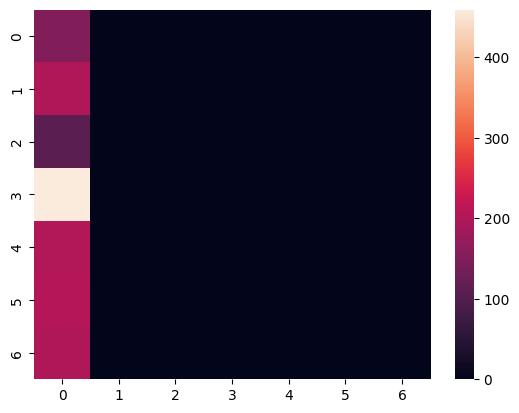

In [58]:
# Evaluate on the test set; display suitable metrics
y_train_pred=model.predict(X_test)
y_pred_classes=np.argmax(y_train_pred,axis=1)
print("Classification Report(test set):")
print(classification_report(y_test, y_pred_classes))

print("Confusion Matrix(test set):")
sns.heatmap(confusion_matrix(y_test,y_pred_classes))

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data

* Report model training results





*   Model having dropout with 50 epochs has less difference between training and validation dataset

   

